<a href="https://colab.research.google.com/github/ArifAygun/ML_Calisma_Notebooklari/blob/main/Graduate_Project_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


from sklearn import ensemble
from sklearn import preprocessing
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor

In [108]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('Flotation_Plant.csv', decimal=",").drop_duplicates()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


In [109]:
# Use a function to reduce memory usage of the dataframe by modifying the datatypes
def reduce_mem_usage(flotation, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = flotation.memory_usage().sum() / 1024**2
    for col in flotation.columns:
        col_type = flotation[col].dtypes
        if col_type in numerics:
            c_min = flotation[col].min()
            c_max = flotation[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    flotation[col] = flotation[col].astype(np.int8)
                elif c_min > flotation.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       flotation[col] = flotation[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    flotation[col] = flotation[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    flotation[col] = flotation[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    flotation[col] = flotation[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    flotation[col] = flotation[col].astype(np.float32)
                else:
                    flotation[col] = flotation[col].astype(np.float64)
    end_mem = flotation.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'
                      .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return flotation

flotation = reduce_mem_usage(flotation)

Mem. usage decreased to 75.83 Mb (46.0% reduction)


- The problem at hand appears to have a misalignment between the frequency of the features and the desired output, which is the percentage of Silica Concentrate (% Silica Concentrate). It is important to note that individual records do not predict the average % Silica Concentrate. Instead, it is the cumulative effect of all parameters over a period of time that results in the averaged % Silica Concentrate.

- From an industrial perspective, it is proposed to group and average all the records based on the % Silica Concentrate in order to address this issue. This approach can be perceived as a shortcut, but it aligns with the industrial understanding of the problem and provides a more meaningful analysis. By consolidating the data in this manner, we can capture the combined impact of various parameters on the averaged % Silica Concentrate.

In [110]:
# Grouping and averaging values by % Silica Concentrate
flotation_grpby = flotation.groupby(['% Silica Concentrate']).mean()

# Extracting % Silica Concentrate values
y = flotation_grpby.index.values.tolist()

# Removing % Iron Concentrate column as it is highly correlated with % Silica Concentrate (0.8)
flotation_grpby = flotation_grpby.drop(columns='% Iron Concentrate')

# Feature Scaling
min_max_scaler = MinMaxScaler()
flotation_scaled = min_max_scaler.fit_transform(flotation_grpby.values)
flotation_scaled = pd.DataFrame(flotation_scaled, columns=flotation_grpby.columns)

- Reducing dimensions is an effective approach to uncovering underlying variances.

In [111]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

# Dimensions reduction with Principal Components Analysis
pca = PCA(n_components=10)
flotation_pca = pca.fit_transform(flotation_scaled)

# Creation of the different datasets for training and testing
x_train, x_test, y_train, y_test = train_test_split(flotation_pca, y, test_size=0.8, random_state=42)

Gradient Boosting Regressor:
R-squared (Test dataset): 0.7596920268033924
MSE (Test dataset): 0.16100644506551529



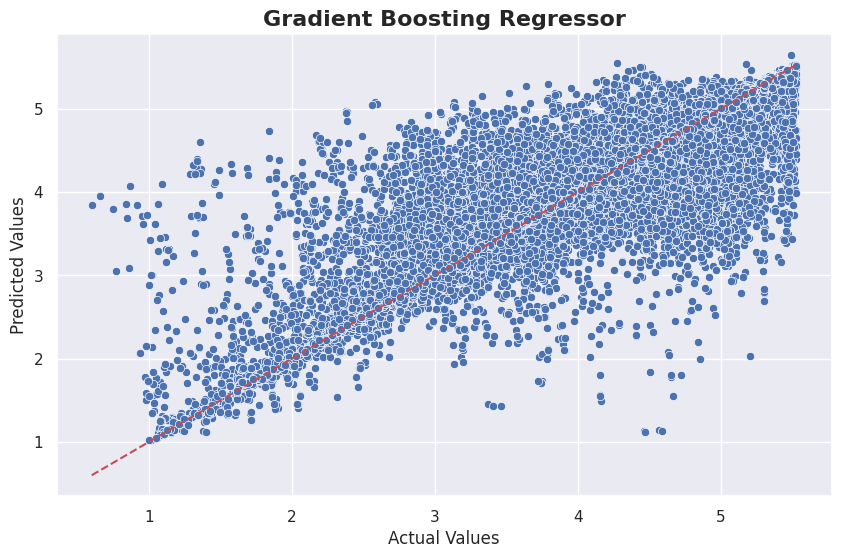

Random Forest Regressor:
R-squared (Test dataset): 0.7884770807802078
MSE (Test dataset): 0.1417204465604459



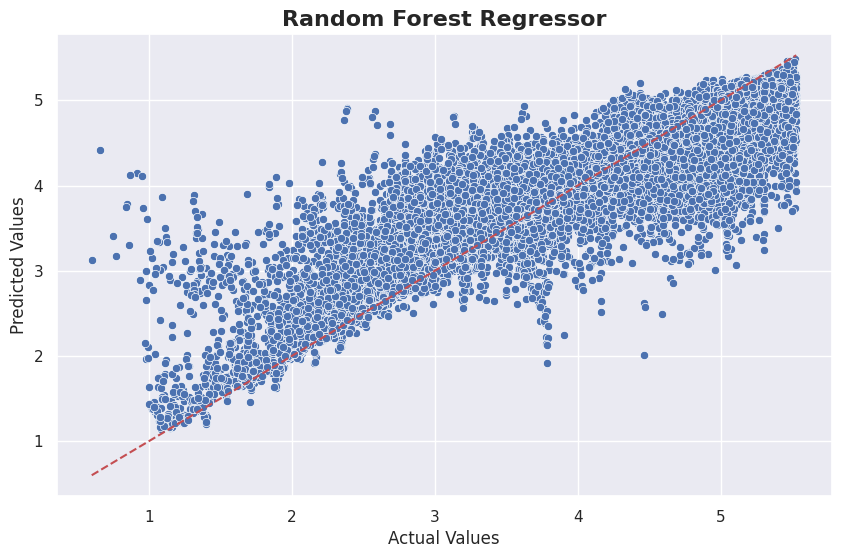

LightGBM Regressor:
R-squared (Test dataset): 0.4892478226517393
MSE (Test dataset): 0.34220417779078494



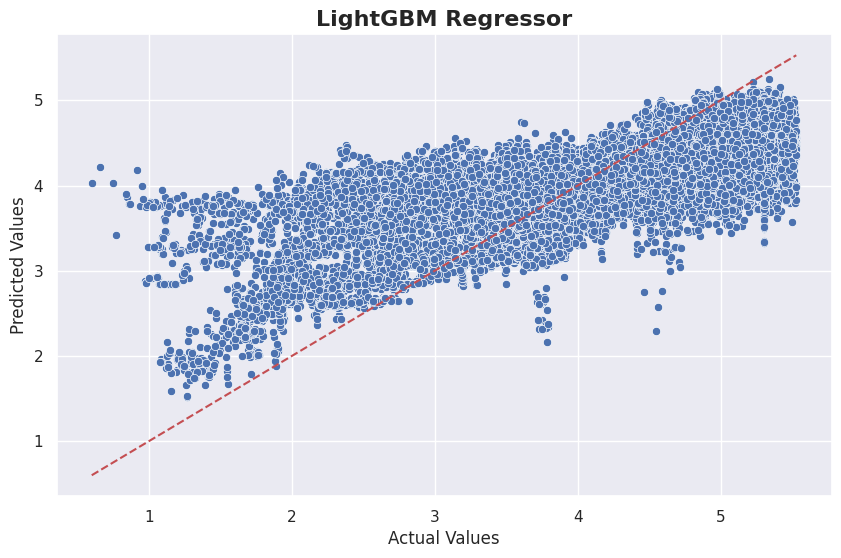

In [112]:
models = [
    {
        'name': 'Gradient Boosting Regressor',
        'model': ensemble.GradientBoostingRegressor(
            n_estimators=120,
            max_depth=16,
            learning_rate=0.1,
            criterion='squared_error'
        )
    },
    {
        'name': 'Random Forest Regressor',
        'model': RandomForestRegressor(
            n_estimators=120,
            max_depth=16,
            criterion='squared_error'
        )
    },
    {
        'name': 'LightGBM Regressor',
        'model': lgb.LGBMRegressor(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.05
        )
    }
]

# Lists to store metric values
model_names = []
r_squared_values = []
mse_values = []

for model in models:
    model_name = model['name']
    model_instance = model['model']

    # Model training
    model_instance.fit(x_train, y_train)

    # Model performance on test data
    r_squared = model_instance.score(x_test, y_test)
    mse = mean_squared_error(y_test, model_instance.predict(x_test))

    # Append metric values
    model_names.append(model_name)
    r_squared_values.append(r_squared)
    mse_values.append(mse)

    print(model_name + ":")
    print("R-squared (Test dataset):", r_squared)
    print("MSE (Test dataset):", mse)
    print()

    # Plotting predicted vs. actual values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=model_instance.predict(x_test))
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Add the line for perfect prediction
    plt.title(model_name, fontsize=16, fontweight='bold')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

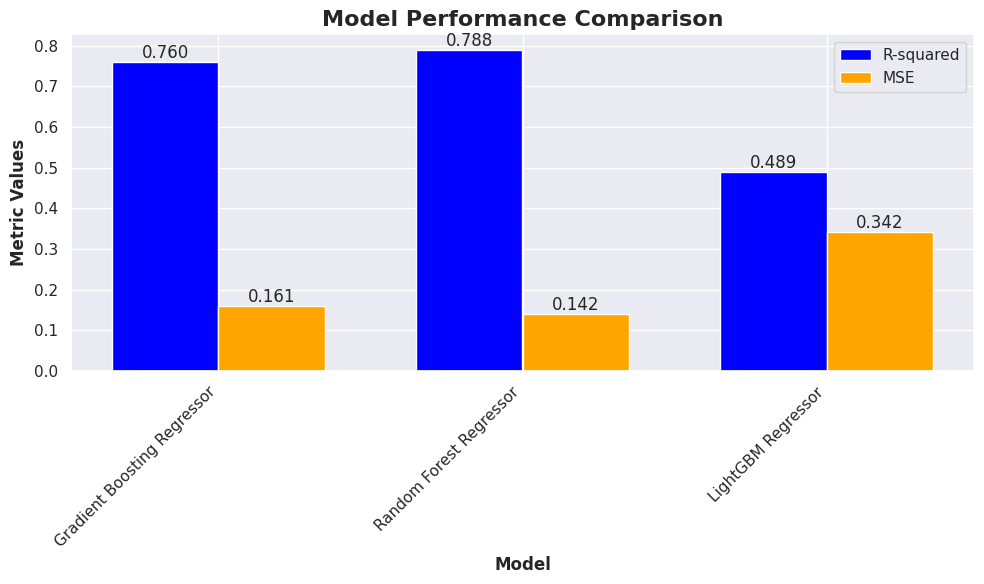

In [113]:
plt.figure(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(models))

# Plot R-squared values
plt.bar(index, r_squared_values, bar_width, label='R-squared', color='blue')
# Plot MSE values
plt.bar(index + bar_width, mse_values, bar_width, label='MSE', color='orange')


for i, value in enumerate(r_squared_values):
    plt.text(i, value, f"{value:.3f}", ha='center', va='bottom')

for i, value in enumerate(mse_values):
    plt.text(i + bar_width, value, f"{value:.3f}", ha='center', va='bottom')

plt.xlabel("Model", fontweight='bold')
plt.ylabel("Metric Values", fontweight='bold')
plt.title("Model Performance Comparison", fontsize=16, fontweight='bold')
plt.xticks(index + bar_width / 2, model_names, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()


Gradient Boosting Regressor:
R-squared (Test dataset): 0.7591002558614832
MSE (Test dataset): 0.1614029318502959
Training Time: 31.26802134513855
Inference Time: 0.5972974300384521



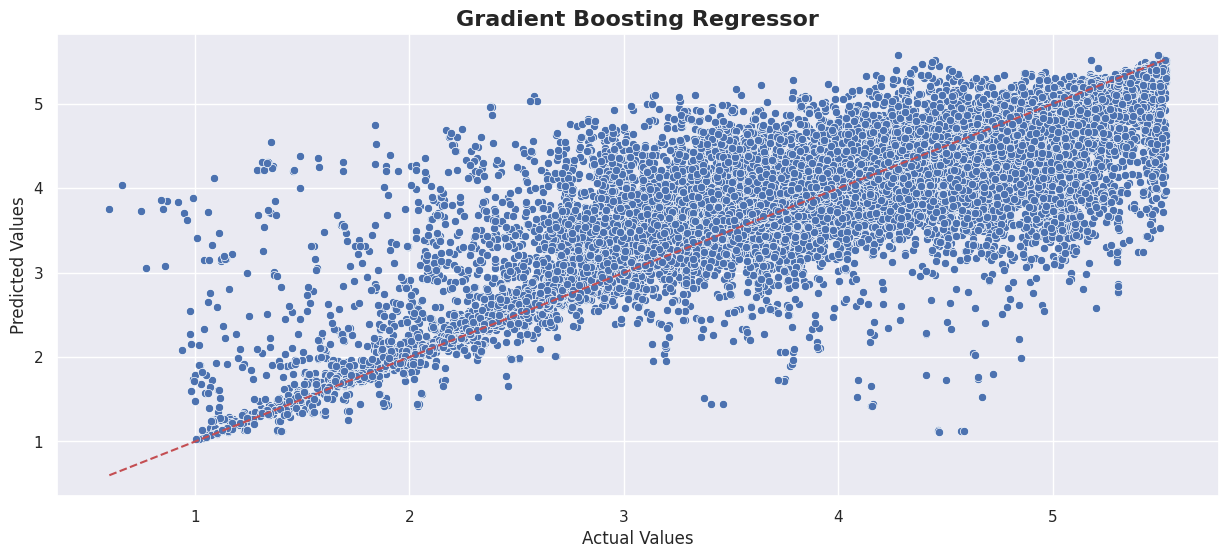

Random Forest Regressor:
R-squared (Test dataset): 0.7912069163823802
MSE (Test dataset): 0.1398914555366672
Training Time: 15.048343896865845
Inference Time: 0.961482048034668



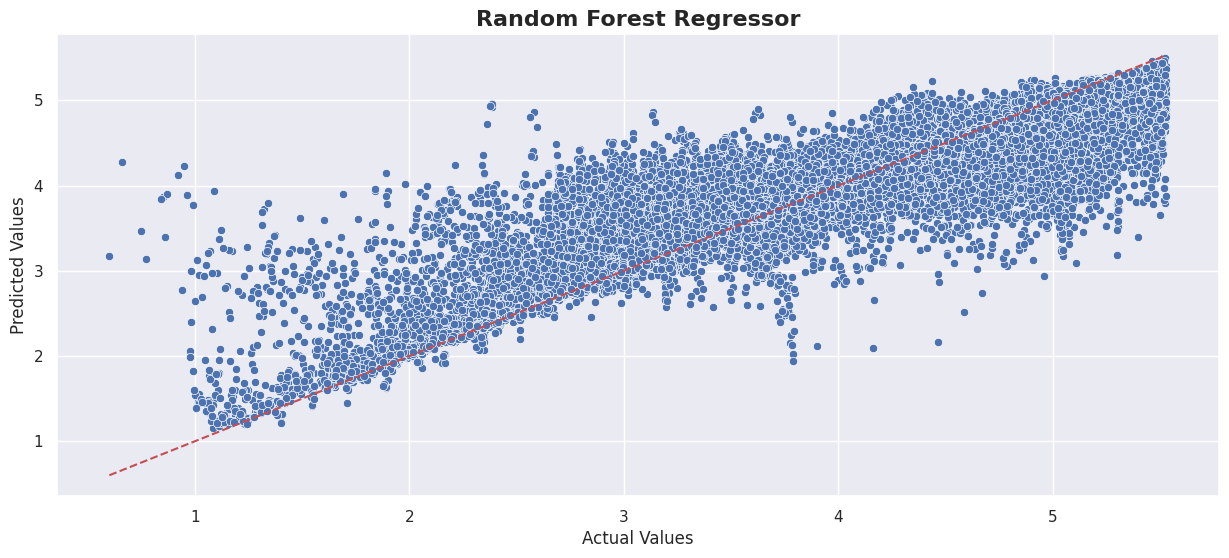

LightGBM Regressor:
R-squared (Test dataset): 0.4892478226517393
MSE (Test dataset): 0.34220417779078494
Training Time: 1.7147390842437744
Inference Time: 0.15453839302062988



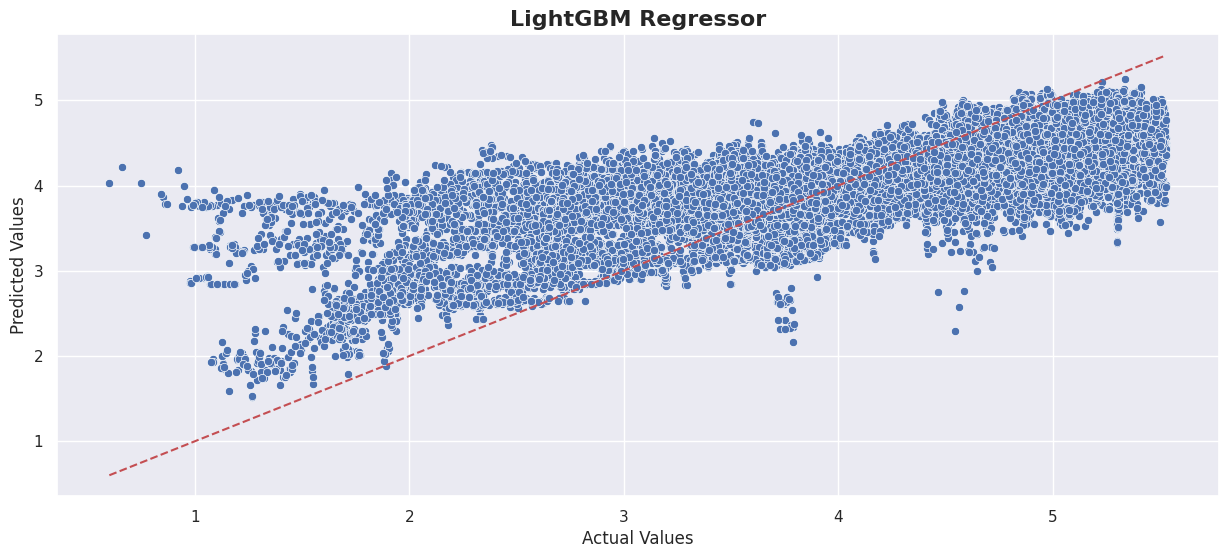

In [153]:
import time
from sklearn import ensemble, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

models = [
    {
        'name': 'Gradient Boosting Regressor',
        'model': ensemble.GradientBoostingRegressor(
            n_estimators=120,
            max_depth=16,
            learning_rate=0.1,
            criterion='squared_error'
        )
    },
    {
        'name': 'Random Forest Regressor',
        'model': RandomForestRegressor(
            n_estimators=120,
            max_depth=16,
            criterion='squared_error'
        )
    },
    {
        'name': 'LightGBM Regressor',
        'model': lgb.LGBMRegressor(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.05
        )
    }
]

# Lists to store metric values and execution times
model_names = []
r_squared_values = []
mse_values = []
execution_times = []

for model in models:
    model_name = model['name']
    model_instance = model['model']

    # Model training
    start_time = time.time()
    model_instance.fit(x_train, y_train)
    training_time = time.time() - start_time

    # Model performance on test data
    start_time = time.time()
    y_pred = model_instance.predict(x_test)
    inference_time = time.time() - start_time

    # Calculate metrics
    r_squared = metrics.r2_score(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)

    # Append metric values and execution times
    model_names.append(model_name)
    r_squared_values.append(r_squared)
    mse_values.append(mse)
    execution_times.append({
        'Training Time': training_time,
        'Inference Time': inference_time
    })

    print(model_name + ":")
    print("R-squared (Test dataset):", r_squared)
    print("MSE (Test dataset):", mse)
    print("Training Time:", training_time)
    print("Inference Time:", inference_time)
    print()

    # Plotting predicted vs. actual values
    plt.figure(figsize=(15, 8))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.title(model_name, fontsize=16, fontweight='bold')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()


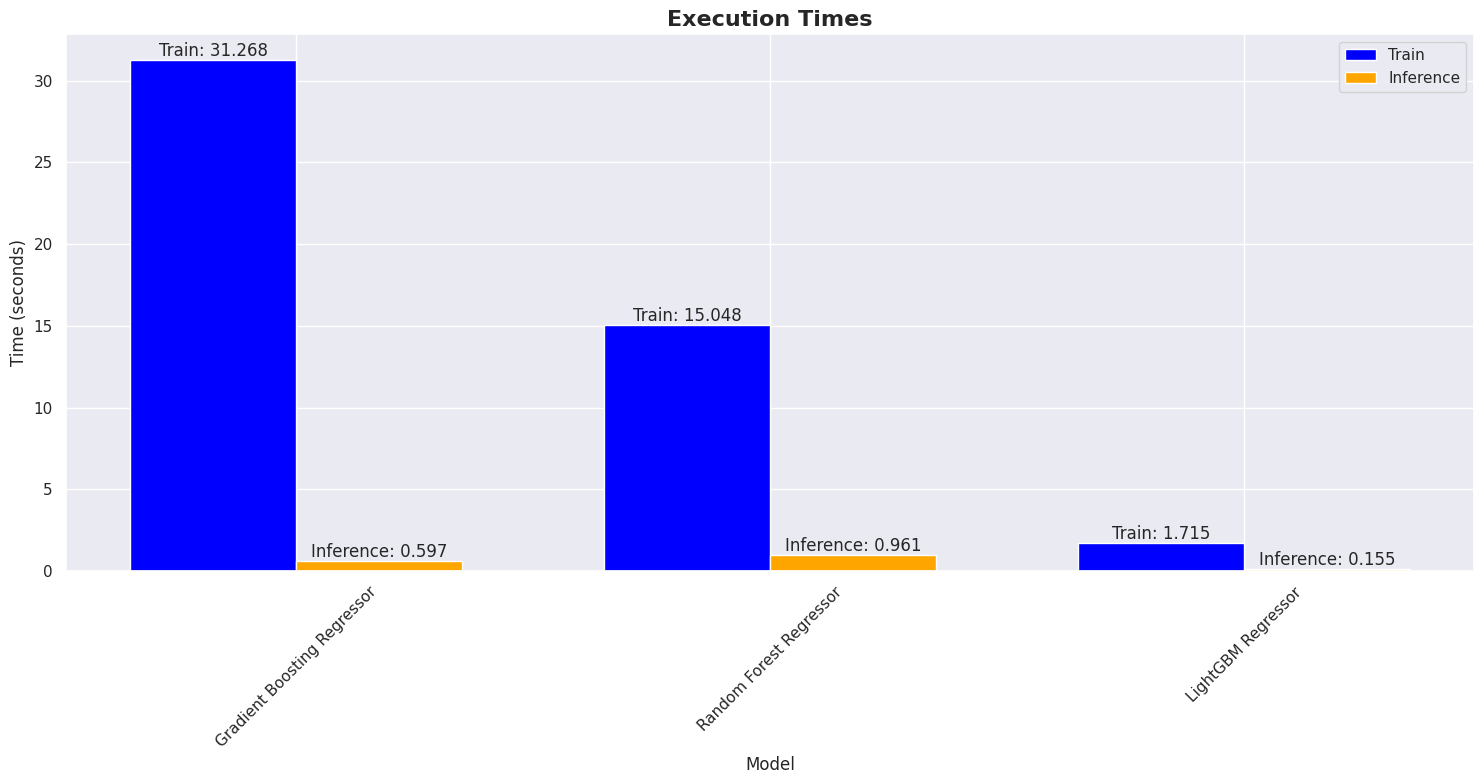

In [156]:
plt.figure(figsize=(15, 8))

execution_times_df = pd.DataFrame(execution_times, index=model_names)

bar_width = 0.35
index = range(len(model_names))

plt.bar(index, execution_times_df.iloc[:, 0], label='Train', color='blue', width=bar_width)
plt.bar([i + bar_width for i in index], execution_times_df.iloc[:, 1], label='Inference', color='orange', width=bar_width)

plt.title("Execution Times", fontsize=16, fontweight='bold')
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.xticks([i + bar_width/2 for i in index], model_names, rotation=45)
plt.legend()

# Add execution time labels
for i, row in enumerate(execution_times_df.iterrows()):
    model_name, execution_time = row
    plt.text(i, execution_time[0], f"Train: {execution_time[0]:.3f}", ha='center', va='bottom')
    plt.text(i + bar_width, execution_time[1], f"Inference: {execution_time[1]:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


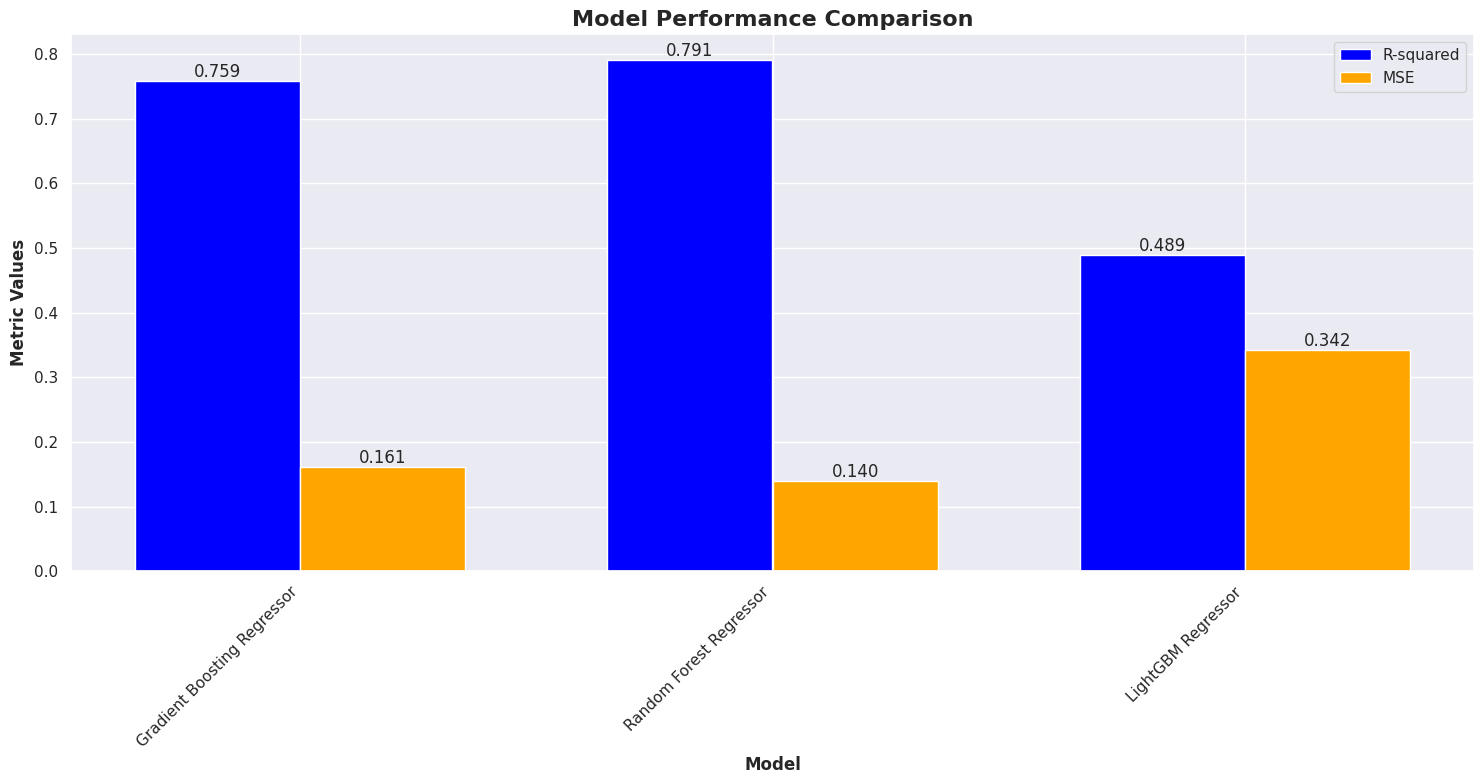

In [157]:
plt.figure(figsize=(15, 8))

bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, r_squared_values, bar_width, label='R-squared', color='blue')
plt.bar(index + bar_width, mse_values, bar_width, label='MSE', color='orange')

for i, value in enumerate(r_squared_values):
    plt.text(i, value, f"{value:.3f}", ha='center', va='bottom')

for i, value in enumerate(mse_values):
    plt.text(i + bar_width, value, f"{value:.3f}", ha='center', va='bottom')

plt.xlabel("Model", fontweight='bold')
plt.ylabel("Metric Values", fontweight='bold')
plt.title("Model Performance Comparison", fontsize=16, fontweight='bold')
plt.xticks(index + bar_width / 2, model_names, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

Comparing the models based on R-squared values:

- The Random Forest Regressor has the highest R-squared value of 0.7904, indicating that it explains a larger proportion of the variance in the test dataset compared to the other models.
- The Gradient Boosting Regressor follows closely with an R-squared value of 0.7531, indicating a good level of performance in explaining the variance.
- The LightGBM Regressor has the lowest R-squared value of 0.4892, suggesting that it might not capture the variance in the test dataset as effectively as the other models.

Comparing the models based on MSE values:

- The Random Forest Regressor has the lowest MSE value of 0.1404, indicating that it has the smallest average squared difference between the predicted and actual values in the test dataset.
- The Gradient Boosting Regressor has a slightly higher MSE value of 0.1654, suggesting a slightly higher average squared difference compared to the Random Forest model.
- The LightGBM Regressor has the highest MSE value of 0.3422, indicating a larger average squared difference between predicted and actual values in the test dataset.

In summary, the Random Forest Regressor performs the best among the three models, exhibiting higher R-squared and lower MSE values. The Gradient Boosting Regressor shows competitive performance, while the LightGBM Regressor has relatively lower performance based on these metrics.